In [16]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [17]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
#import make_models;reload(make_models);from make_models import *
import make_models2;reload(make_models2);from make_models2 import *

from functools import partial
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from datetime import datetime

import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [18]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [19]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [20]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=100
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64,64,64,1), 
                                            latent_dim=32, 
                                            batch_size = batch_size, 
                                            disentangle=True,
                                            gamma=100,
                                            kernel_size = 3,
                                            filters = 48,
                                            intermediate_dim = 128,
                                            nlayers = 2,
                                            bias=True)


#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G1'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G100_DisTrue'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/APR_4th_D32DTrue_G100'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/20210919-1144'
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/20210920-2122'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [21]:
%%time 
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'

#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
#fn = 'Feb04_0524_D16B1G100_DTrue'
#fn = os.path.join(fdir,'Mar18_1312_CVAE_D16B1G1_adam_rData2')
#fn = os.path.join(fdir,'Mar20_2125_CVAE_D16B1G1_ADAM_Bspline_r2_new')

fn = os.path.join(fdir,fn)
fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

CPU times: user 1.16 s, sys: 538 ms, total: 1.7 s
Wall time: 2.45 s


In [22]:
%%time
cvae_mse = list()
for s in range(ABIDE_data.shape[0]):
    data_batch = ABIDE_data[s,:,:,:]
    if patients[s]:
        vec = np.hstack((z_encoder.predict(data_batch[np.newaxis,:,:,:])[2],s_encoder.predict(data_batch[np.newaxis,:,:,:])[2]))
    else:
        vec = np.hstack((z_encoder.predict(data_batch[np.newaxis,:,:,:])[2][0,:],np.zeros(16)))

    pred = cvae_decoder.predict(vec[np.newaxis,:])[0,:,:,:,0]
    cvae_mse.append(((data_batch-pred)**2).mean())

CPU times: user 57.3 s, sys: 7.97 s, total: 1min 5s
Wall time: 1min 3s


In [23]:
%%time
vae_mse = list()
for s in range(ABIDE_data.shape[0]):
    data_batch = ABIDE_data[s,:,:,:]
    pred = decoder.predict(encoder.predict(data_batch[np.newaxis,:,:,:])[2])[0,:,:,:,0]
    vae_mse.append(((data_batch-pred)**2).mean())

CPU times: user 51.4 s, sys: 8.12 s, total: 59.5 s
Wall time: 58.2 s


In [30]:
vae_mse = np.array(vae_mse)[patients]
cvae_mse = np.array(cvae_mse)[patients]

In [31]:
xs = [0,1]
ys = [vae_mse.mean(),cvae_mse.mean()]
se = [vae_mse.std(),cvae_mse.std()]

<ErrorbarContainer object of 3 artists>

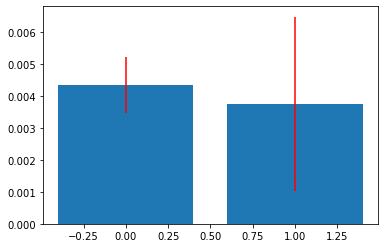

In [32]:
plt.bar(xs,ys)
plt.errorbar(xs,ys,se,fmt='r ')

In [34]:
from scipy import stats
stats.ttest_rel(vae_mse,cvae_mse)

Ttest_relResult(statistic=4.801078778415541, pvalue=2.1257084293141804e-06)

(array([447.,  11.,   3.,   2.,   4.,   0.,   0.,   1.,   0.,   2.]),
 array([0.00152819, 0.00486414, 0.00820009, 0.01153604, 0.01487199,
        0.01820794, 0.02154389, 0.02487984, 0.02821579, 0.03155174,
        0.03488769], dtype=float32),
 <BarContainer object of 10 artists>)

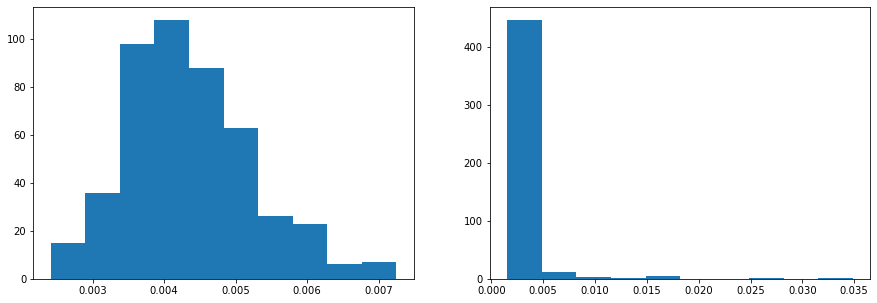

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(vae_mse)

plt.subplot(1,2,2)
plt.hist(cvae_mse)

In [38]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.hist(vae_mse)

# plt.subplot(1,2,2)
# plt.hist(cvae_mse)

In [39]:
# batch_size = 16
# b = 0
# data_batch = ABIDE_data[b*batch_size:b*batch_size+batch_size,:,:,:]
# mse = ((data_batch-vae.predict(data_batch)[:,:,:,:,0])**2).mean(axis=-1).mean(axis=-1).mean(axis=-1)

# for b in tqdm(range(1,int(np.floor(patients.sum()/16)))):
#     b_idx = np.arange(b*batch_size,b*batch_size+b)
#     data_batch = ABIDE_data[b_idx,:,:,:]
#     mse = np.hstack((mse,((data_batch-vae.predict(data_batch)[:,:,:,:,0])**2).mean(axis=-1).mean(axis=-1).mean(axis=-1)))

In [40]:
# data_batch.shape

In [41]:
# plt.hist(mse)

NEW 10 SAMPLE

In [42]:
n_samples = 10

data_latent_vec = np.load('../Data/latent_vecs2.npz')

salient_vec_abide = data_latent_vec['salient_vec_abide']
background_vec_abide = data_latent_vec['background_vec_abide']
#vae_vec_abide = data_latent_vec['vae_vec_abide']
salient_vec_sfari = data_latent_vec['salient_vec_sfari']
background_vec_sfari = data_latent_vec['background_vec_sfari']
#vae_vec_sfari = data_latent_vec['vae_vec_sfari']

# salient_vec_abide = np.array([s_encoder.predict(ABIDE_data[:,:,:,:])[2] for _ in range(n_samples)])
# background_vec_abide = np.array([z_encoder.predict(ABIDE_data[:,:,:,:])[2] for _ in range(n_samples)])
vae_vec_abide = np.array([encoder.predict(ABIDE_data[:,:,:,:])[2] for _ in tqdm(range(n_samples))])

# salient_vec_sfari = np.array([s_encoder.predict(SFARI_data[:,:,:,:])[2] for _ in range(n_samples)])
# background_vec_sfari = np.array([z_encoder.predict(SFARI_data[:,:,:,:])[2] for _ in range(n_samples)])
vae_vec_sfari = np.array([encoder.predict(SFARI_data[:,:,:,:])[2] for _ in tqdm(range(n_samples))])

fn = '../Data/latent_vecs2-new.npz'
np.savez_compressed(fn, 
                    salient_vec_abide=salient_vec_abide,
                    background_vec_abide=background_vec_abide,
                    vae_vec_abide=vae_vec_abide,
                   salient_vec_sfari=salient_vec_sfari,
                   background_vec_sfari=background_vec_sfari,
                   vae_vec_sfari=vae_vec_sfari)

In [51]:
n_samples = 100

data_latent_vec = np.load('../Data/latent_vecs100.npz')

salient_vec_abide = data_latent_vec['salient_vec_abide']
background_vec_abide = data_latent_vec['background_vec_abide']
#vae_vec_abide = data_latent_vec['vae_vec_abide']
salient_vec_sfari = data_latent_vec['salient_vec_sfari']
background_vec_sfari = data_latent_vec['background_vec_sfari']
#vae_vec_sfari = data_latent_vec['vae_vec_sfari']

# salient_vec_abide = np.array([s_encoder.predict(ABIDE_data[:,:,:,:])[2] for _ in range(n_samples)])
# background_vec_abide = np.array([z_encoder.predict(ABIDE_data[:,:,:,:])[2] for _ in range(n_samples)])
vae_vec_abide = np.array([encoder.predict(ABIDE_data[:,:,:,:])[2] for _ in tqdm(range(n_samples))])

# salient_vec_sfari = np.array([s_encoder.predict(SFARI_data[:,:,:,:])[2] for _ in range(n_samples)])
# background_vec_sfari = np.array([z_encoder.predict(SFARI_data[:,:,:,:])[2] for _ in range(n_samples)])
vae_vec_sfari = np.array([encoder.predict(SFARI_data[:,:,:,:])[2] for _ in tqdm(range(n_samples))])

fn = '../Data/latent_vecs100-new.npz'
np.savez_compressed(fn, 
                    salient_vec_abide=salient_vec_abide,
                    background_vec_abide=background_vec_abide,
                    vae_vec_abide=vae_vec_abide,
                   salient_vec_sfari=salient_vec_sfari,
                   background_vec_sfari=background_vec_sfari,
                   vae_vec_sfari=vae_vec_sfari)

100%|██████████| 100/100 [00:17<00:00,  5.63it/s]
